# Fig. 7: Model evaluation

In [1]:
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('seaborn-colorblind')

2018-10-11 18:30:40,428 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
class ShapeLoss(argus_shapes.models.ShapeLossMixin):
    def _calcs_el_curr_map(self):
        pass
    def build_ganglion_cell_layer(self):
        pass
shape_loss = ShapeLoss()

In [3]:
results_dir = '../results/trial1cv'
col_score = 'best_train_score'
col_groupby = ['subject', 'modelname', 'idx_fold']

In [4]:
# After repeatedely fitting the model, find the runs with the best training score:
files = argus_shapes.extract_best_pickle_files(results_dir, col_score, col_groupby)

In [5]:
y_true = []
y_pred = []
for file in files:
    yt, yp, _, specifics = pickle.load(open(file, 'rb'))
    yt = yt[0].drop(columns=['image', 'x_center', 'y_center'])
    yp = yp[0].drop(columns=['image', 'x_center', 'y_center'])
    for g in col_groupby:
        yt[g] = specifics[g]
    yt['orientation'] = np.rad2deg(yt['orientation'])
    yp['orientation'] = np.rad2deg(yp['orientation'])
    y_true.append(yt)
    y_pred.append(yp)
ytyp = pd.concat((pd.concat(y_true),
                  pd.concat(y_pred).add_suffix('_p')),
                 axis=1)

In [6]:
subjects = ytyp.subject.unique().tolist()
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
all_ticks = (([0, 6], [0, 2400], [-90, 90], [0, 1]),
             ([0, 6], [0, 6000], [-90, 90], [0, 1]),
             ([0, 6], [0, 2000], [-90, 90], [0, 1]),
             ([0, 6], [0, 18000], [-90, 90], [0, 1]))
labels = ['n/a', 'area (pixels)', 'orientation (deg)', 'elongation']

S2 -0.0449326184016
[168    E10
161    E10
106    E10
169    E10
80     E10
Name: electrode, dtype: object, 168     583
161     815
106    1043
169    1705
80     1045
Name: area, dtype: int64, 168   -19.811840
161     6.178419
106    73.494066
169    -9.181082
80     39.028602
Name: orientation, dtype: float64, 168    0.802291
161    0.961438
106    0.702568
169    0.396574
80     0.969626
Name: eccentricity, dtype: float64]
S3 -0.112961408362
[237    C1
245    C1
234    C1
249    C1
255    C1
Name: electrode, dtype: object, 237    680
245    596
234    891
249    831
255    747
Name: area, dtype: int64, 237   -82.800905
245   -69.062891
234   -78.044872
249   -54.807870
255   -83.266293
Name: orientation, dtype: float64, 237    0.998046
245    0.996586
234    0.997525
249    0.997883
255    0.998229
Name: eccentricity, dtype: float64]
S3 -0.112527569936
[180    C3
188    C3
198    C3
186    C3
197    C3
Name: electrode, dtype: object, 180    408
188    261
198    494
186    443
197  

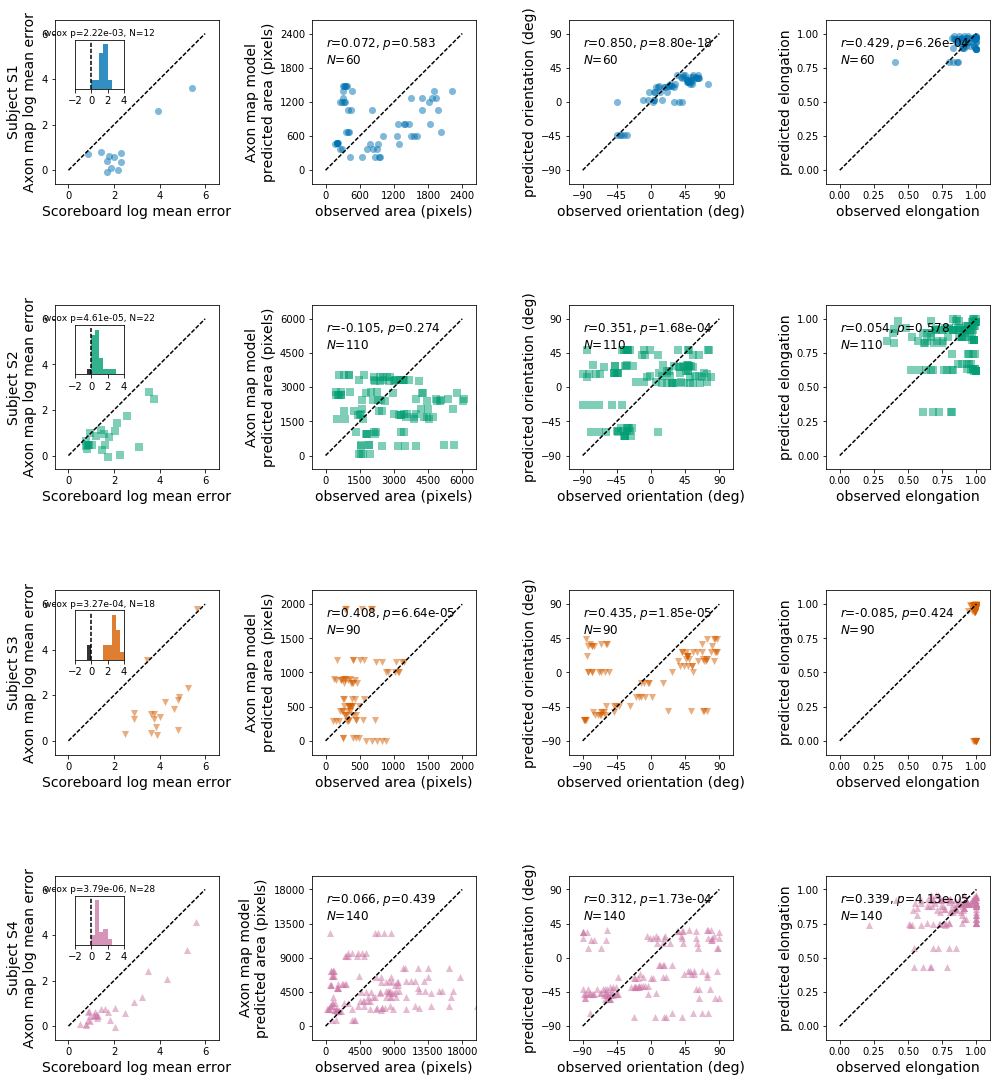

In [15]:
plotcols = ['AvsC', 'area', 'orientation', 'eccentricity']
fs = 14
hist_range = (-2, 4)
fig, axes = plt.subplots(ncols=len(plotcols), nrows=len(subjects), 
                         figsize=(14, 4 * len(subjects)))
for (subject, data), marker, color, ticks, axrow in zip(ytyp.groupby('subject'), markers, colors, all_ticks, axes):
    for col, ax, tick, label in zip(plotcols, axrow, ticks, labels):
        lim = [1.1 * tick[0] - 0.1 * tick[1], 1.1 * tick[1] - 0.1 * tick[0]]
        if col == 'AvsC':
            # First column: show Model A vs Model C scatter plot
            xvals = []
            yvals = []
            els = []
            n_folds = len(data.idx_fold.unique())
            for (_, rows) in data.groupby('idx_fold'):
                rows_a = rows[rows.modelname == 'A']
                rows_c = rows[rows.modelname == 'C']
                els.append([rows_a.electrode, rows_a.area, rows_a.orientation, rows_a.eccentricity])
                xvals.append(shape_loss.calc_shape_loss(rows_a, rows_a, suffix='_p') / len(rows_a))
                yvals.append(shape_loss.calc_shape_loss(rows_c, rows_c, suffix='_p') / len(rows_c))
            xvals = np.log10(np.nan_to_num(xvals))
            yvals = np.log10(np.nan_to_num(yvals))
            ax.scatter(xvals, yvals, marker=marker, s=50, c=color, alpha=0.5)
            ax.set_xlabel('Scoreboard log mean error', fontsize=fs)
            ax.set_ylabel('Subject %s\nAxon map log mean error' % subject, fontsize=fs)
            ax.set_xticks(np.linspace(*tick, num=4))
            ax.set_yticks(np.linspace(*tick, num=4))
            
            axins = inset_axes(ax, width="30%", height="30%", loc=2, borderpad=2)
            n, bins, patches = axins.hist(xvals - yvals,
                                          bins=12, range=hist_range, 
                                          color=color, alpha=0.8)
            [patches[i].set_facecolor('k') for i in range(4)]
            [p.set_edgecolor('k') for p in patches]
            a = axins.axis()
            axins.plot([0, 0], [0, a[3]], 'k--')
            axins.set_yticks([])
            axins.set_xticks(np.int32(np.linspace(*hist_range, num=4)))
            axins.set_xlim(*hist_range)
            w = spst.wilcoxon(xvals, yvals)
            axins.set_title('wcox p=%.2e, N=%d' % (w.pvalue, len(xvals)), fontsize=9)
            for x, y, e in zip(xvals, yvals, els):
                if x - y < 0:
                    print(subject, x-y)
                    print(e)
        else:
            rows = data[data.modelname == 'C']
            ax.scatter(rows[col], rows[col + '_p'], marker=marker, s=50, c=color, alpha=0.5)
            ax.set_xlabel('observed %s' % label, fontsize=fs)
            ax.set_ylabel('predicted %s' % label, fontsize=fs)
            slope, intercept, rval, pval, _ = spst.linregress(rows[col], rows[col + '_p'])
            if pval >= 0.001:
                ax.text(tick[0], tick[1], "$r$=%.3f, $p$=%.3f\n$N$=%d" % (rval, pval, len(rows)), 
                        va='top', ha='left', fontsize=fs - 2)
            else:
                ax.text(tick[0], tick[1], "$r$=%.3f, $p$=%.2e\n$N$=%d" % (rval, pval, len(rows)),
                        va='top', ha='left', fontsize=fs - 2)
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
        ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
        ax.axis('square')
        ax.set_xlim(*lim)
        ax.set_ylim(*lim)
    axrow[1].set_ylabel('Axon map model\npredicted %s' % labels[1], fontsize=fs)
fig.tight_layout();
fig.savefig('fig7-scatter.svg')